In [1]:
import caffe
import lmdb
import os
import caffe.proto.caffe_pb2
from caffe.io import datum_to_array
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.spatial import distance

In [2]:
def read_from_db(db_dir):
    lmdb_env = lmdb.open(db_dir)
    lmdb_txn = lmdb_env.begin()
    lmdb_cursor = lmdb_txn.cursor()
    datum = caffe.proto.caffe_pb2.Datum()

    D = []

    for idx, (key, value) in enumerate(lmdb_cursor):
        datum.ParseFromString(value)
        data = caffe.io.datum_to_array(datum)
        D.append(data.flatten())

    lmdb_env.close()
    return D

In [3]:
def read_labels(label_file):
    D = []
    with open(label_file,'rb') as f:
        for line in f:
            D.append(int(line.split(' ')[1]))
    return D

In [33]:
def read_file_names(label_file):
    D = []
    with open(label_file,'rb') as f:
        for line in f:
            D.append(line.split(' ')[0])
    return D

In [4]:
X_test = read_from_db('/Users/ecsark/Documents/visualdb/project/wikiart/test_vgg_feature_fc7')

In [5]:
y_test = read_labels('/Users/ecsark/Documents/visualdb/project/wikiart/test.txt')

In [36]:
file_test = read_file_names('/Users/ecsark/Documents/visualdb/project/wikiart/test.txt')
file_train = read_file_names('/Users/ecsark/Documents/visualdb/project/wikiart/train.txt')

In [6]:
X_train = read_from_db('/Users/ecsark/Documents/visualdb/project/wikiart/train_vgg_feature_fc7')
y_train = read_labels('/Users/ecsark/Documents/visualdb/project/wikiart/train.txt')

In [22]:
print X_test[2]

[ 0.51584458  0.          0.         ...,  0.          0.          0.        ]


In [24]:
label_names = []
with open("/Users/ecsark/Documents/visualdb/project/artwork-explorer/data/label.txt", 'rb') as f:
    for line in f:
        tokens = line.split(" ")[1:]
        label_names.append(" ".join(tokens))
n_classes = len(label_names)

In [8]:
from sklearn import svm
clf = svm.SVC()
clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0, degree=3, gamma=0.0,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [11]:
y_pred = clf.predict(X_test)
error = sum([1 if p!=g else 0 for (p, g) in zip(y_pred, y_test)])
print 1.0 - 1.0*error/len(y_test)

0.5005


In [8]:
import cPickle as pickle
clf = pickle.load(open('/Users/ecsark/Documents/visualdb/project/artwork-explorer/model/svc_vgg_fc7.pk', 'rb'))

In [19]:
clf.predict(X_test[0])[0]

2

In [12]:
print list(y_pred[:20])
print list(y_test[:20])

[2, 5, 1, 5, 4, 1, 4, 8, 5, 8, 3, 3, 0, 4, 9, 4, 3, 2, 5, 2]
[2, 2, 7, 5, 4, 6, 4, 8, 6, 8, 5, 3, 0, 4, 0, 4, 3, 7, 5, 4]


Confusion matrix, without normalization
[[107   4  15   8  10   8  10   5  16  17]
 [  5 138   3   5   9   2  13  18   3   4]
 [ 24   4  83   7   4  24   8   3  26  17]
 [  8   5  10 105   3  24  22  10   3  10]
 [  6  23   7   6 131   0   7  10   6   4]
 [ 19   2  25  31   2  80  16   2   8  15]
 [ 11  16  10  29  11   8  80  20   9   6]
 [  9  24   9  14  18   3  30  80   6   7]
 [ 15   6  12   2   8   7   3   7 127  13]
 [ 23  17  20  10  11   6  13  12  18  70]]
Normalized confusion matrix
[[ 0.54  0.02  0.07  0.04  0.05  0.04  0.05  0.03  0.08  0.09]
 [ 0.03  0.69  0.01  0.03  0.04  0.01  0.07  0.09  0.01  0.02]
 [ 0.12  0.02  0.41  0.04  0.02  0.12  0.04  0.01  0.13  0.09]
 [ 0.04  0.03  0.05  0.53  0.01  0.12  0.11  0.05  0.01  0.05]
 [ 0.03  0.12  0.04  0.03  0.66  0.    0.04  0.05  0.03  0.02]
 [ 0.1   0.01  0.12  0.15  0.01  0.4   0.08  0.01  0.04  0.07]
 [ 0.06  0.08  0.05  0.14  0.06  0.04  0.4   0.1   0.04  0.03]
 [ 0.04  0.12  0.04  0.07  0.09  0.01  0.15  0.4   0.03  0.0

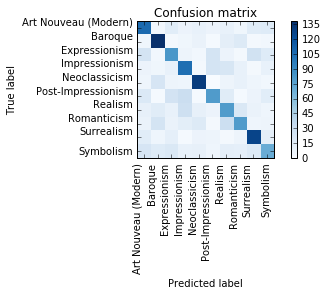

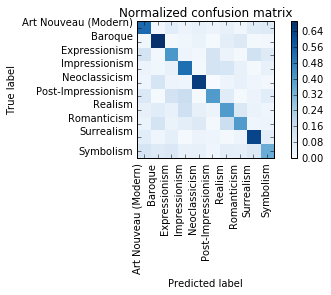

In [18]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(label_names))
    plt.xticks(tick_marks, label_names, rotation=90)
    plt.yticks(tick_marks, label_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
 

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)
print('Confusion matrix, without normalization')
print(cm)
plt.figure()
plot_confusion_matrix(cm)

# Normalize the confusion matrix by row (i.e by the number of samples
# in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure()
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')

plt.show()

In [29]:
def findMostSimilar(X, x_query, k=5):
    dist = distance.cdist(X, np.array([x_query]), 'euclidean')
    return dist.flatten().argsort()[:k]

In [9]:
k_min_idx = findMostSimilar(X_train, X_test[4], 10)
print k_min_idx
print [y_train[i] for i in k_min_idx]

[7146 5474  818 7384 6578 6699 3300 2315 7498 5900]
[4, 4, 4, 4, 4, 4, 4, 4, 4, 1]


In [10]:
for i in range(20):
    k_min_idx = findMostSimilar(X_train, X_test[i], 10)
    labels = [y_train[j] for j in k_min_idx]
    print y_test[i], max(set(labels), key=labels.count), labels

2 1 [7, 1, 1, 1, 1, 8, 9, 3, 8, 2]
2 5 [5, 2, 2, 5, 5, 5, 5, 6, 5, 2]
7 1 [4, 7, 1, 7, 4, 2, 1, 1, 5, 2]
5 3 [3, 3, 6, 3, 3, 9, 6, 6, 1, 5]
4 4 [4, 4, 4, 4, 4, 4, 4, 4, 4, 1]
6 1 [1, 1, 2, 7, 7, 7, 1, 1, 1, 5]
4 4 [4, 1, 4, 5, 4, 7, 4, 4, 4, 5]
8 8 [7, 8, 0, 9, 4, 2, 8, 8, 5, 8]
6 5 [3, 0, 4, 7, 5, 5, 7, 9, 7, 5]
8 1 [9, 1, 9, 1, 6, 1, 5, 2, 1, 9]
5 3 [3, 3, 3, 5, 5, 3, 3, 3, 3, 6]
3 3 [3, 3, 5, 3, 0, 2, 9, 3, 6, 6]
0 0 [0, 0, 1, 0, 5, 8, 5, 5, 0, 1]
4 4 [4, 4, 4, 8, 8, 4, 4, 4, 0, 2]
0 1 [8, 1, 2, 0, 9, 1, 1, 1, 0, 3]
4 6 [5, 6, 4, 7, 0, 2, 6, 6, 1, 4]
3 3 [5, 3, 5, 5, 3, 3, 7, 5, 3, 3]
7 2 [7, 2, 1, 9, 7, 9, 2, 2, 3, 1]
5 5 [5, 5, 5, 0, 3, 0, 5, 2, 5, 3]
4 1 [6, 0, 2, 4, 1, 1, 7, 6, 9, 9]


In [12]:
y_pred_max = []

for x in X_test:
    k_min_idx = findMostSimilar(X_train, x, 10)
    labels = [y_train[i] for i in k_min_idx]
    y_pred_max.append(max(set(labels), key=labels.count))

error_max = sum([1 if p!=g else 0 for (p, g) in zip(y_pred_max, y_test)])
print 1.0 - 1.0*error_max/len(y_pred_max)

0.3675


In [20]:
def get_decision(fts, clf):
    decisions = clf.decision_function(fts)
    scores = []
    idx = 0
    for i in range(n_classes):
        i_score = []
        for j in range(i):
            i_score.append(-scores[j][i])
        i_score.append(0)
        for k in range(n_classes - i - 1):
            i_score.append(decisions[0][idx])
            idx += 1
        scores.append(i_score)
    return scores

In [40]:
scores_train = []
for x in X_train:
    scores_train.append(get_decision(x, clf))

In [38]:
dec = np.array(get_decision(X_test[3], clf)).sum(axis=1)
print dec
k_sim_idx = findMostSimilar(score_train, dec, 6)
for i in k_sim_idx:
    print file_train[i], y_train[i]

[ 2.29280195 -8.03743984 -0.29822775  2.31513291 -6.94292965  4.91613087
  0.97853165 -2.33642472  1.3338013   5.77862328]
/Users/ecsark/Documents/visualdb/project/wikiart/images/odilon-redon_nasturtiums.jpg 9
/Users/ecsark/Documents/visualdb/project/wikiart/images/maxime-maufra_passing-through-the-bar-1898.jpg 5
/Users/ecsark/Documents/visualdb/project/wikiart/images/salvador-dali_tolle-tolle-crucifige-eum-john-19-15-1967.jpg 9
/Users/ecsark/Documents/visualdb/project/wikiart/images/winston-churchill_interior-at-breccles.jpg 3
/Users/ecsark/Documents/visualdb/project/wikiart/images/nicholas-roerich_ladakh-4.jpg 9
/Users/ecsark/Documents/visualdb/project/wikiart/images/ramon-oviedo_fantasmas-del-ca-averal.jpg 2
/Users/ecsark/Documents/visualdb/project/wikiart/images/konstantin-somov_frontispiece-of-the-journal-world-of-art.jpg 9
/Users/ecsark/Documents/visualdb/project/wikiart/images/nicholas-roerich_castle-of-king-gesar-1929.jpg 9
/Users/ecsark/Documents/visualdb/project/wikiart/image

In [79]:
score_rank_zero = [(np.array(decision)>0).sum(axis=1).tolist() for decision in scores_train]

In [83]:
dec = np.array(get_decision(X_test[4], clf))

k_sim_idx = findMostSimilar(score_rank_zero, (np.array(dec)>0).sum(axis=1).tolist(), 6)
for i in k_sim_idx:
    print y_train[i], file_train[i], all_score[i]

7 /Users/ecsark/Documents/visualdb/project/wikiart/images/gustave-dore_the-prophet-jeremiah.jpg 1723.82641066
4 /Users/ecsark/Documents/visualdb/project/wikiart/images/jacques-louis-david_napoleoncrossing-the-alps-at-the-st-bernard-pass-20th-may-1800-1801.jpg 484.945312105
8 /Users/ecsark/Documents/visualdb/project/wikiart/images/m-c-escher_atrani-coast-of-amalfi-1.jpg 1465.56173868
8 /Users/ecsark/Documents/visualdb/project/wikiart/images/rene-magritte_when-the-hour-strikes-1965.jpg 1563.95893825
4 /Users/ecsark/Documents/visualdb/project/wikiart/images/antonio-canova_eurydice-1776.jpg 1439.54200808
4 /Users/ecsark/Documents/visualdb/project/wikiart/images/pierre-paul-prud-hon_the-soul-breaking-the-bonds-that-attach-to-the-land.jpg 1396.15379576
